In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, explained_variance_score, max_error, d2_absolute_error_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from surprise import SVD, Reader, Dataset
from collections import defaultdict
import gzip
from surprise import SVDpp
from surprise.model_selection import cross_validate

### TRAIN DATASET

In [2]:
df_train = pd.read_csv('interactions_train.csv')

In [3]:
df_train.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


<Axes: xlabel='rating', ylabel='Count'>

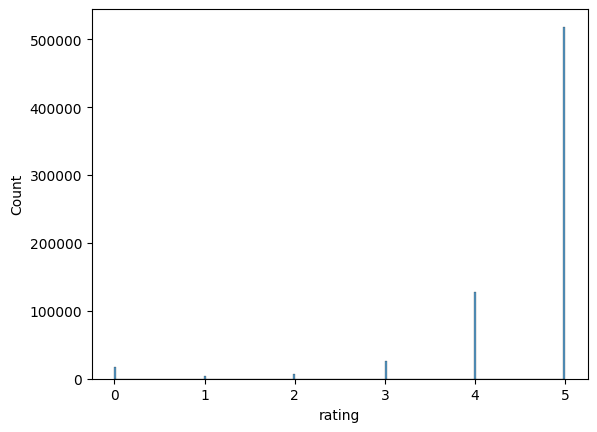

In [4]:
sns.histplot(data=df_train['rating'])

### TEST DATASET

In [5]:
df_test = pd.read_csv('interactions_test.csv')

### CODE

In [6]:
df_train.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [7]:
df_test.head()

,user_id,recipe_id,date,rating,u,i
0,8937,44551,2005-12-23,4.0,2,173538
1,56680,126118,2006-10-07,4.0,16,177847
2,349752,219596,2008-04-12,0.0,26,89896
3,628951,82783,2007-11-13,2.0,45,172637
4,92816,435013,2013-07-31,3.0,52,177935


In [8]:
df_balanced = pd.concat([
    df_train[df_train['rating'] == 5.0].sample(n=25000, random_state=42),  # Sample 50k 5.0 ratings
    df_train[df_train['rating'] == 4.0].sample(n=25000, random_state=42),  
    df_train[(df_train['rating'] != 5.0) & (df_train['rating'] != 4.0)]  # Include all other ratings
])

In [9]:
df_balanced

,user_id,recipe_id,date,rating,u,i
627283,47892,327077,2012-06-15,5.0,305,45792
679919,80353,458060,2014-09-10,5.0,377,129673
100674,21399,117270,2005-08-23,5.0,1376,103290
666889,28636,376310,2013-11-10,5.0,711,102530
598777,226863,344776,2011-08-30,5.0,267,138107
...,...,...,...,...,...,...
698857,218535,322598,2018-12-09,1.0,1411,84439
698872,198154,67930,2018-12-13,3.0,395,49765
698889,2001513060,367414,2018-12-17,1.0,294,6785
698893,527509,78552,2018-12-17,2.0,9136,126870


In [10]:
df_test

,user_id,recipe_id,date,rating,u,i
0,8937,44551,2005-12-23,4.0,2,173538
1,56680,126118,2006-10-07,4.0,16,177847
2,349752,219596,2008-04-12,0.0,26,89896
3,628951,82783,2007-11-13,2.0,45,172637
4,92816,435013,2013-07-31,3.0,52,177935
...,...,...,...,...,...,...
12450,101053,179011,2009-01-03,5.0,25054,130258
12451,252205,81398,2005-12-26,2.0,25055,152255
12452,624305,142984,2011-01-15,1.0,25057,139864
12453,173575,104842,2004-12-18,3.0,25059,140646


### FIT THE DATA

In [11]:
reader = Reader(rating_scale=(0, 5))

data = Dataset.load_from_df(df_train[['u', 'i', 'rating']], reader=reader)

trainset = data.build_full_trainset()

model = SVD()

model.fit(trainset)

### VALIDATE

In [12]:
df_valid = pd.read_csv('interactions_validation.csv')

In [13]:
validset = df_valid.to_dict('records')

In [14]:
preds = []
y_true = []
for i in validset:
    prediction = model.predict(uid=i['u'], iid=i['i'], verbose=False)
    preds.append(prediction.est)
    y_true.append(i['rating'])

In [15]:
mse = mean_squared_error(y_pred=preds, y_true=y_true)
rmse = root_mean_squared_error(y_pred=preds, y_true=y_true)
r2 = r2_score(y_pred=preds, y_true=y_true)
mae = mean_absolute_error(y_pred=preds, y_true=y_true)
mse, rmse, r2, mae

(1.6290336784883932, 1.27633603666448, 0.040238533425907, 0.8039701329833888)

In [16]:
data = Dataset.load_from_df(df_valid[['u', 'i', 'rating']], reader=reader)
cross_validate(model, data, measures=["RMSE", "MAE", "MSE"], cv=5, verbose=True)

Evaluating RMSE, MAE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2832  1.3119  1.3285  1.3631  1.2210  1.3015  0.0478  
MAE (testset)     0.9182  0.9328  0.9494  0.9607  0.8936  0.9309  0.0236  
MSE (testset)     1.6466  1.7210  1.7648  1.8581  1.4909  1.6963  0.1234  
Fit time          0.10    0.09    0.09    0.09    0.09    0.09    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.28321012, 1.31187158, 1.3284742 , 1.36311542, 1.22100971]),
 'test_mae': array([0.91823651, 0.93281738, 0.94937876, 0.96066612, 0.89361266]),
 'test_mse': array([1.64662821, 1.72100703, 1.76484371, 1.85808364, 1.49086471]),
 'fit_time': (0.09865140914916992,
  0.0921320915222168,
  0.08956742286682129,
  0.09322214126586914,
  0.09041047096252441),
 'test_time': (0.008636236190795898,
  0.010027885437011719,
  0.007039785385131836,
  0.007566690444946289,
  0.0070569515228271484)}

### TEST

In [17]:
testset = df_test.to_dict('records')

In [18]:
preds = []
y_true = []
for i in testset:
    prediction = model.predict(uid=i['u'], iid=i['i'], verbose=False)
    preds.append(prediction.est)
    y_true.append(i['rating'])

In [19]:
mse = mean_squared_error(y_pred=preds, y_true=y_true)
rmse = root_mean_squared_error(y_pred=preds, y_true=y_true)
r2 = r2_score(y_pred=preds, y_true=y_true)
mae = mean_absolute_error(y_pred=preds, y_true=y_true)
mse, rmse, r2, mae

(1.7750138799912507,
 1.3322964685051337,
 0.009172850631929297,
 0.9528192242716871)

In [20]:
data = Dataset.load_from_df(df_test[['u', 'i', 'rating']], reader=reader)
cross_validate(model, data, measures=["RMSE", "MAE", "MSE"], cv=5, verbose=True)

Evaluating RMSE, MAE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3790  1.2921  1.3450  1.3622  1.3103  1.3377  0.0322  
MAE (testset)     0.9839  0.9381  0.9548  0.9714  0.9405  0.9578  0.0177  
MSE (testset)     1.9016  1.6695  1.8089  1.8555  1.7168  1.7905  0.0860  
Fit time          0.15    0.17    0.17    0.19    0.17    0.17    0.01    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.37896863, 1.29209845, 1.34495358, 1.36216796, 1.3102841 ]),
 'test_mae': array([0.98392708, 0.93809554, 0.95481084, 0.97144694, 0.94051852]),
 'test_mse': array([1.90155448, 1.66951841, 1.80890012, 1.85550155, 1.71684441]),
 'fit_time': (0.15476560592651367,
  0.16994833946228027,
  0.17062020301818848,
  0.19249796867370605,
  0.16874170303344727),
 'test_time': (0.011166572570800781,
  0.013077020645141602,
  0.01307535171508789,
  0.01405644416809082,
  0.013560295104980469)}